# Problem set 6: Classification (solution)

## Description

Explore different algorithms to classify Old Bailey cases as involving "stealing" or "other."

## Imports and setup

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from   sklearn.decomposition import TruncatedSVD
from   sklearn.feature_extraction.text import TfidfVectorizer

# Our input text file
old_bailey_file = os.path.join('..', '..', 'data', 'old_bailey', 'old_bailey.txt')

## Old Bailey records

We'll work with a set of 3,090 short text documents from the Old Bailey archive, just as we did last week.

In [2]:
# Read cases in as a list of strings
with open(old_bailey_file, 'r') as f:
    bailey = [doc for doc in f.read().split('\n\n')] # split on consecutive newlines
print("Total documents:", len(bailey))

Total documents: 3090


In [3]:
# Freebie function to assign gold labels to corpus texts
def make_labels(corpus, keyword='steal'):
    '''
    Takes a corpus of documents and a keyword string.
    Assigns labels based on coöccurrence of keyword and ' indicted for ' in first sentence of document.
    Returns an array of class labels (1=member, 0=nonmember).
    '''
    from nltk import word_tokenize, sent_tokenize
    import re
    find_indictment = re.compile(' indicted for ')
    find_keyword = re.compile(keyword)
    labels = []
    for doc in corpus:
        first_sentence = sent_tokenize(doc)[0].lower()
        if find_indictment.search(first_sentence) and find_keyword.search(first_sentence):
            labels.append(1)
        else:
            labels.append(0)
    return np.array(labels)

In [4]:
# Generate gold labels
y_bailey = make_labels(bailey, keyword='steal')
print("Label vector shape:", y_bailey.shape)
print("Stealing cases:", np.sum(y_bailey))
print("Fraction of cases labeled 'stealing':", round(np.sum(y_bailey)/len(y_bailey),3))

Label vector shape: (3090,)
Stealing cases: 2676
Fraction of cases labeled 'stealing': 0.866


In [5]:
# Baseline accuracy and F1
#  What if we just guess 1 every time?
baseline_accuracy = np.sum(y_bailey)/len(y_bailey)
baseline_precision = baseline_accuracy
baseline_recall = 1.0
baseline_f1 = 2*baseline_precision*baseline_recall/(baseline_precision+baseline_recall)
print("Baseline accuracy:", round(baseline_accuracy, 3))
print("Baseline F1:", round(baseline_f1, 3))

Baseline accuracy: 0.866
Baseline F1: 0.928


## 1. Vectorize (5 points)

Using the vectorizer defined below, transform the input documents into a TFIDF-weighted document-term matrix. Store your vectorized output in a varaible named `X_bailey` and print the shape of the resulting matrix.

Note: This is a straight carry-over from the last problem set.

In [6]:
# Custom preprocessing to remove escaped characters in input
def pre_proc(x):
    '''
    Takes a unicode string.
    Lowercases, strips accents, and removes some escapes.
    Returns a standardized version of the string.
    '''
    import unicodedata
    return unicodedata.normalize('NFKD', x.replace("\'", "'").replace("\ in\ form", " inform").lower().strip())

# Set up vectorizer
vectorizer = TfidfVectorizer(
    encoding='utf-8',
    preprocessor=pre_proc,
    min_df=2, # Note this
    max_df=0.8, # This, too
    binary=False,
    norm='l2',
    use_idf=True # And this
)

# Your code here
X_bailey = vectorizer.fit_transform(bailey)

# Get the dimensions of the doc-term matrix
print("Matrix shape:", X_bailey.shape)

Matrix shape: (3090, 8638)


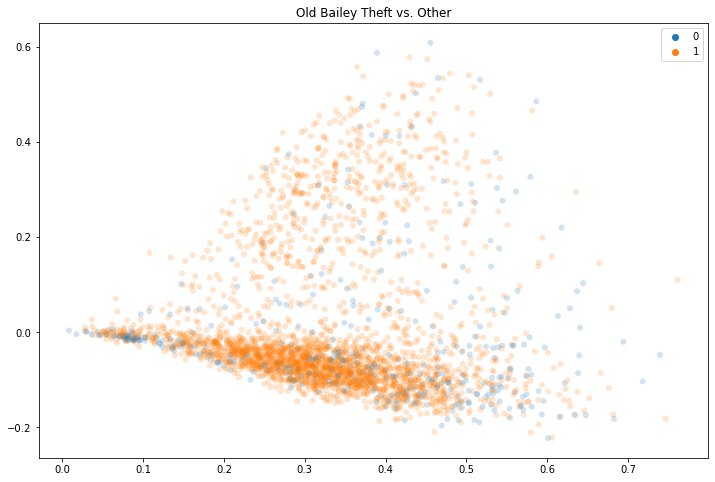

In [7]:
# Freebie: plot our data
coords_bailey = TruncatedSVD(n_components=2).fit_transform(X_bailey)

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=coords_bailey[:, 0], 
    y=coords_bailey[:, 1],
    hue=y_bailey,
    alpha=0.2,
    linewidth=0
)
plt.title('Old Bailey Theft vs. Other')
plt.show()

## Freebies: Classification and cross-validation how-to

Below is a sample of how to set up classifiers and perform cross-validation.

In [8]:
# Cross-validate two simple classifiers on our data
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Classifers to test
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_bailey, # feature matrix
        y_bailey, # gold labels
        cv=10, #number of folds
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

In [9]:
# Examine the performance of our simple classifiers
# Freebie function to summarize and display classifier scores
def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    import pandas as pd
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [10]:
# Compare cross-validation scores
# Note that colorization of the `time` columns is counterintuitive
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
kNN,0.003900,0.114422,0.872492,0.925005,0.746616,0.872492
Logit,0.129610,0.002662,0.909709,0.950408,0.721966,0.909709


## 2. Add results from three more classifiers (25 points)

* Set up the three classifiers imported below (decision tree, random forest, and multinomial naïve Bayes). Use **default** parameters only (that is, do not set any classifier parameters yourself). (10 points total)
* Cross-validate the three new classifiers, saving the scoring output to the same `scores` dictionary as above. (10 points)
* Use the `compare_scores` function to display the scores of all five classifiers. (5 points)

This all takes less than 30 seconds total to run on my laptop.

In [11]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

more_classifiers = {
    'Decision tree':DecisionTreeClassifier(),
    'Random forest':RandomForestClassifier(),
    'Naïve Bayes':MultinomialNB()
}

for classifier in more_classifiers:
    scores[classifier] = cross_validate(more_classifiers[classifier], X_bailey, y_bailey, cv=10, scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'])

compare_scores(scores)

CPU times: user 19.4 s, sys: 128 ms, total: 19.5 s
Wall time: 19.9 s


,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
kNN,0.003900,0.114422,0.872492,0.925005,0.746616,0.872492
Logit,0.129610,0.002662,0.909709,0.950408,0.721966,0.909709
Decision tree,0.506805,0.005221,0.954045,0.973496,0.900074,0.954045
Random forest,1.424617,0.033464,0.947573,0.970583,0.864400,0.947573
Naïve Bayes,0.004482,0.002732,0.874757,0.932580,0.525308,0.874757


## 3. Compare the unoptimized performance of the five classifiers (10 points)

How would you summarize the performance of the five classifiers prior to any optimization? Consider classification performance relative to one another and to baseline, as well as computation time. 

**Your comparison here**

## 4. Improve two of the classifiers (40 points)

See how much you can improve the performance of any two of the five classifiers. You might try:

* Changing the vectorization parameters. (Hint: it can help to use fewer input features).
* Changing the classifier parameters. 
    * See the `sklearn` [documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) for your chosen classifiers for a list of available options.
* Trying a different classifier entirely.
    * If you do this, make sure you give careful consideration to the settings of the new classifier, too. **Using default parameters will result in a score of zero.**
    
No matter what you try, you must **document your process**. In other words, don't just change settings in a cell and run it over and over. You should iterate over different options, storing your cross-validation scores for each combination of settings.

Finally, display your results using the `compare_scores` function.

Points breakdown: 20 points total for each classifier, of which 10 are for iterating over a range of parameter values, 5 are for performing cross validation correctly and displaying summary scores, and 5 are for actually improving performance (by any amount). 

In [12]:
# Your code here

## 5. Examine and discuss classification errors (20 points)

First, rerun your best-performing classifier over the full corpus and save the resulting labels as `y_best`. (10 points)

To do this, first set up a classifier with your optimized paramters; then use the classifier's `fit` method to train the model; then use the fitted classifer's `predict` method to compute the labels. In schematic form, this looks like:

```
y_labels = Classifier(options).fit(X, y).predict(X)
```

(Note that training and testing over the same data is poor practice, since it encourages overfitting. We avoided that problem by using cross validation above. We're doing it here only for ease of examination.)

Then use the `pull_errors` function below to read through some cases that were incorrectly classified by your best-perfoming classifer. Write a paragraph that summarizes any patterns you can identify in the mis-classified cases. Can you explain what may be confusing the classifier? Does your analysis suggest any avenues for improved performance? (10 points)

In [16]:
# Your code here
dectree = DecisionTreeClassifier(max_depth=5).fit(X_bailey, y_bailey)
y_best = dectree.predict(X_bailey)

In [14]:
# Function to examine some classification errors
def pull_errors(labels, gold_labels=y_bailey, corpus=bailey, n=3):
    '''
    Takes:
        an array of computed labels
        an array of gold (correct) labels
        a list of corpus documents
        an int of cases to display
    '''
    import pandas as pd
    labeled_cases = pd.DataFrame(
        {
            'gold':gold_labels, 
            'computed':labels,
            'text':corpus
        }   
    )
    errors = labeled_cases.loc[labeled_cases.gold != labeled_cases.computed]
    with pd.option_context('display.max_colwidth', None):
        display(errors.sample(n))

In [17]:
# Pull errors
pull_errors(y_best, y_bailey, bailey, n=3)

,gold,computed,text
1144,0,1,". , and , were indicted for stealing on the 15th of November , one box, value 2 s. 6 d. ; the goods of . MR. ANDREWS conducted the prosecution. . I am waggoner to Mr. Joseph White of Winwaldon, in Essex, about twenty-six miles off. On the 15th of November, about seven o'clock in the morning, I drove my waggon into Whitechapel , the box was on the top of the waggon, secured by a cord; I took it off to deliver it to Mr. Parkins, it was a blue wooden box; my waggon stood at the door near the church; I set it on the shafts, I had a boy with me, I went to the hind part of the waggon, to tie the rope, and in the mean time it was stolen, it contained apples. Reynolds came up, and I saw three men run up George-yard. . I am an officer. About seven o'clock in the morning, I was in Whitechapel, and saw the four prisoners, with three or four others, stopping at the corner of George-yard, about twenty-five yards from the waggon, I knew them well before. When I had passed them about fifty yards, I looked back, and saw they had advanced near the waggon, and at that instant, Mason went from the others, and took the box off the shafts, and returned with it on his shoulder to the others. All ran away together as far as George-yard; Mason, Daley, and another, (not in custody,) ran up George-yard with the box. Clark and Hitchings went with the rest up Whitechapel. I\ in\ formed the man of his loss, and we followed up George-yard, but they turned into a court, and I lost them. I went into Whitechapel, and took Hitchings and Clark in less than five minutes. About an hour after, I apprehended Mason, at the corner of George-yard. Daley was taken on Sunday. I am certain of them all. It was a blue wooden box. DALEY. Q. Did you not say I took it - A. Never. . - I am an officer, I apprehended Daley on Sunday evening, at a house in George-yard, I told him I took him for stealing a box out of Whitechapel; he said, he thought there were two or three committed already for it; I said, Yes, and I wanted him also; I took him from the description Reynolds gave me. MASON'S Defence. I was in bed at the time. MASON - GUILTY . Aged 23. DALEY - GUILTY . Aged 22. CLARK - GUILTY . Aged 18. Transported for Seven Years . HITCHINS - GUILTY . Aged 18. Confined One Year , and Whipped . Second Middlesex Jury, before Mr. Common Sergeant."
593,1,0,"was indicted for stealing, on the 24th of November , 100 lbs. of lead, value 10 s. belonging to the , and fixed to a building of his . . I am a labourer, at Isleworth , I know the Duke of Northumberland's. On the morning of the 24th of November, I was at work in a garden, in Wheatley-lane, about eight o'clock. I saw the prisoner and another man come down the lane, with each a sack on his shoulder, which appeared very heavy. I watched the prisoner to the corner of the lane, he put his bag down and looked about - then took it up, and both went together towards Brentford. I followed them and sent for assistance - he stopped to rest. I followed them to Iseleworth Park - when they saw me following them, they took towards Isleworth they saw me - then threw down the bag and ran away. I did not see him again till he was taken up. I am sure the prisoner is one of the men. I knew him before. I followed them to the lodge - Neal came out and overtook the other man who has been convicted. I did not see the prisoner again till about a fortnight ago, when I took him myself, at Mr. Hunt's, a chimney-sweeper's, at Brentford. When I went to enquire for him he was denied - I found him in a bed-room. I left the bags with Winkworth. . I went in pursuit of the men. I can not swear the prisoner is one of them. I found the lead and remained with it till the constable took it. I saw it fitted to the Duke's observatory staircase - it fitted exactly, and was quite fresh cut; there was 107 lbs. in the two bags. . I am carpenter to the Duke of Northumberland. On this morning I was going home to my breakfast, about half-past eight o

**Your discussion here**